In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from cv_proj_imports import *
from cv_proj_consts import *
from cv_proj_utils import *
from cv_proj_explore_map5_metric import *
from cv_proj_trainval_split import *
from cv_proj_arcface import *
import pickle
import bz2

/home/crazy_slime/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
train_image_files

(#25361) [/home/crazy_slime/projects/humpback-whale-identification/data/train_processed/0000e88ab.jpg,/home/crazy_slime/projects/humpback-whale-identification/data/train_processed/0001f9222.jpg,/home/crazy_slime/projects/humpback-whale-identification/data/train_processed/00029d126.jpg,/home/crazy_slime/projects/humpback-whale-identification/data/train_processed/00050a15a.jpg,/home/crazy_slime/projects/humpback-whale-identification/data/train_processed/0005c1ef8.jpg,/home/crazy_slime/projects/humpback-whale-identification/data/train_processed/0006e997e.jpg,/home/crazy_slime/projects/humpback-whale-identification/data/train_processed/000a6daec.jpg,/home/crazy_slime/projects/humpback-whale-identification/data/train_processed/000f0f2bf.jpg,/home/crazy_slime/projects/humpback-whale-identification/data/train_processed/0016b897a.jpg,/home/crazy_slime/projects/humpback-whale-identification/data/train_processed/001c1ac5f.jpg...]

In [4]:
def filename_label(o, **kwargs):
    "Label `item` with the file name."
    return o.name if isinstance(o, Path) else o.split(os.path.sep)[-1]

def img_to_ftrs_fn(img_fn, **kwargs):
    return f'efficientnet_features/{img_fn}.pickle.bz2'

def load_features(fn):
    with bz2.BZ2File(fn, 'rb') as f:
        ftrs = pickle.load(f)        
        ftrs = ftrs.reshape([2560, 16, 16])
        return ftrs

In [5]:
filename_label(train_image_files[0])

'0000e88ab.jpg'

In [6]:
img_to_ftrs_fn(filename_label(train_image_files[0]))

'efficientnet_features/0000e88ab.jpg.pickle.bz2'

In [7]:
load_features(img_to_ftrs_fn(filename_label(train_image_files[0])))

tensor([[[-0.2784, -0.2244, -0.0561,  ..., -0.1600, -0.2300, -0.1739],
         [-0.2728, -0.1924, -0.0668,  ..., -0.1066, -0.2777, -0.2356],
         [-0.1760, -0.1652, -0.0684,  ..., -0.0199, -0.2751, -0.2783],
         ...,
         [-0.2672, -0.2252,  0.3983,  ..., -0.1399, -0.1911, -0.2203],
         [-0.2653, -0.2758, -0.2490,  ..., -0.1826, -0.2719, -0.2607],
         [-0.1654, -0.1325, -0.2108,  ..., -0.2388, -0.1130, -0.1723]],

        [[-0.0565, -0.2765, -0.1020,  ...,  0.0088, -0.2318, -0.2641],
         [-0.0330, -0.2126, -0.2108,  ...,  0.0750,  0.3298,  0.0243],
         [ 0.0324, -0.1210, -0.1989,  ...,  0.1432,  0.0707, -0.0210],
         ...,
         [ 0.0290, -0.2122, -0.1400,  ..., -0.1988, -0.2197, -0.0424],
         [-0.0868, -0.0905, -0.1923,  ..., -0.1579, -0.1461, -0.0492],
         [-0.2784, -0.2494, -0.1922,  ..., -0.1414, -0.2359, -0.2724]],

        [[ 0.7538,  3.3877, -0.1900,  ..., -0.2744,  0.8184,  1.2700],
         [-0.2534, -0.2698, -0.2461,  ..., -0

In [8]:
# transformations
# we get the filenames as input, and output:
# x as the image feature vector
# y as the whale name
tfms_x = [filename_label, img_to_ftrs_fn, load_features]
tfms_y = [filename_label, lambda o: train_labels_dict[o], Categorize()]
tfms = [tfms_x, tfms_y]
ds_tfms = [ToTensor()]

dl_tfms = [Cuda()]

In [9]:
trainval_splits = get_trainval_splits()
train_ds = DataSource(train_image_files, tfms, splits=trainval_splits)

We will use 1078 whales for initial train/val


In [10]:
train_db = train_ds.databunch(after_item=ds_tfms, after_batch=dl_tfms, bs=32, shuffle_train=True, num_workers=0)

In [11]:
class PassthroughNet(nn.Sequential):
    def __init__(self, pretrained=True, **kwargs):
        super().__init__()
    
    def forward(self, x):
        # reshape to original shape of EfficientNet-B7 features
        return x.reshape([2560, 16, 16])

In [12]:
from fastai2.vision.learner import _resnet_split

opt_func = partial(Adam, lr=5e-3, wd=0.01)

arcface_loss = ArcFaceLoss().cuda() # this may not be needed just try it out
custom_head = Customhead(5120,1078,1024)

model = create_cnn_model(
    arch=PassthroughNet,
    nc = 1078,
    cut = -2,
    pretrained = True,
    custom_head=custom_head
)

learn = Learner(train_db, model, loss_func=arcface_loss, splitter = _resnet_split, opt_func=opt_func, metrics=[error_rate, mapk])
learn.unfreeze()

In [13]:
learn.model

Sequential(
  (0): Sequential()
  (1): Customhead(
    (head): Sequential(
      (0): AdaptiveConcatPool2d(
        (ap): AdaptiveAvgPool2d(output_size=1)
        (mp): AdaptiveMaxPool2d(output_size=1)
      )
      (1): Flatten()
      (2): BatchNorm1d(5120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.25, inplace=False)
      (4): Linear(in_features=5120, out_features=2048, bias=True)
      (5): ReLU(inplace=True)
      (6): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=2048, out_features=1024, bias=True)
    )
    (arc_margin): ArcMarginProduct()
  )
)

In [14]:
#chosen_lr = find_best_lr(learn); f"Chosen LR: {chosen_lr}"


In [15]:
learn_cbs = [
    EarlyStoppingCallback(monitor='valid_loss', patience=6),
    SaveModelCallback(monitor='valid_loss', fname='embedding_efficientnetb7_20191031_arcface_best_v3'),
    ReduceLROnPlateau(monitor='valid_loss', patience=2)
]

#learn.fit(500, lr=chosen_lr, cbs=learn_cbs)

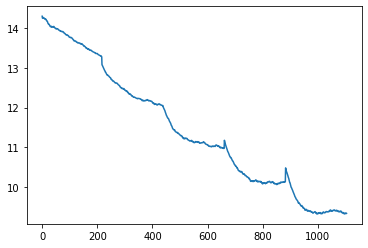

In [16]:
learn.fit(5, lr=0.001, cbs=learn_cbs)
learn.recorder.plot_loss()

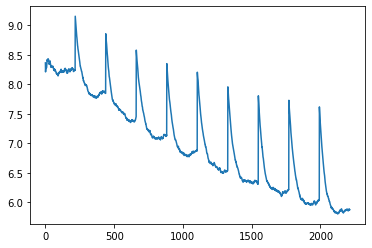

In [17]:
learn.fit(10, lr=0.0005, cbs=learn_cbs)
learn.recorder.plot_loss()

In [19]:
learn.fit(30, lr=0.00005, cbs=learn_cbs)
learn.recorder.plot_loss()

Epoch 9: reducing lr to 5e-06


IndexError: list index out of range

Epoch 3: reducing lr to 5.000000000000001e-07
Epoch 4: reducing lr to 5.000000000000001e-08
No improvement since epoch -1: early stopping


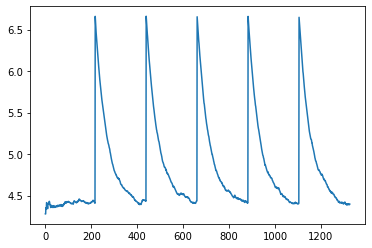

In [20]:
learn.fit(30, lr=0.000005, cbs=learn_cbs)
learn.recorder.plot_loss()